# Анализ факторов влияющих на привлекательность стартапа и прогнозирование его успешности на краудфандинговой платформе Kickstarter.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import researchpy as rp
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

In [2]:
ks = pd.read_csv('ks-projects-201801.csv')

In [3]:
ks.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [4]:
ks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
ID                  378661 non-null int64
name                378657 non-null object
category            378661 non-null object
main_category       378661 non-null object
currency            378661 non-null object
deadline            378661 non-null object
goal                378661 non-null float64
launched            378661 non-null object
pledged             378661 non-null float64
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null object
usd pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


In [5]:
ks.state.unique()

array(['failed', 'canceled', 'successful', 'live', 'undefined',
       'suspended'], dtype=object)

Удалим проекты которые ещё не завершены так как по ним нет результата и их не так много.

In [6]:
ks[ks['state'] == 'live'].ID.count()

2799

In [7]:
ks = ks[(ks.state != 'live')]

Добавим колонку, в которой будет результат переведенный из строкового в числовой.

In [8]:
def result_ (df):
    if df['state'] == 'canceled':
        return 0
    if df['usd_pledged_real'] - df['usd_goal_real'] > 0:
        return 1
    else:
        return 0

In [9]:
ks['result'] = ks.apply(result_, axis=1)

Оставим только те проекты по которым есть результат (положительный или отрицательный)

Добавьм колонку содержащую количество дней сбора, а так же колонки с годом и месяцем начала сбора средств.

In [10]:
ks['launched'] = pd.to_datetime(ks.launched).dt.normalize()

In [11]:
ks['amount_days']= pd.to_datetime(ks.deadline) - ks.launched

In [12]:
ks['amount_days'] = (ks.amount_days / np.timedelta64(1, 'D')).astype(int) 

In [13]:
ks['year_start'] = ks['launched'].dt.year

In [14]:
ks['month_start'] = ks['launched'].dt.month

Добавим колонку содержащую разницу между полученными средствами и запрашиваемыми

In [15]:
ks['diff_money'] = ks['usd_pledged_real'] - ks['usd_goal_real']

Удалим колонку usd pledged так как есть более точная альтернатива - usd_pledged_real, к тому же без пропущеных значений

А так же колонки goal, pledged так как есть альтернатива со значениями конвертированными в доллары(usd_pledged_real, usd_goal_real), соответственно колонка currency тоже больше не нужна. 

В столбцах deadline и launched так же более нет необходимости.

ID как таковой тоже не нужен в данной работе. Предварительно изменим отсутствующие имена проектов на соответствующие ID для того чтобы не было NaN значений.

In [16]:
ks.name.fillna(ks.ID, inplace=True)

In [17]:
print(ks.columns)

Index(['ID', 'name', 'category', 'main_category', 'currency', 'deadline',
       'goal', 'launched', 'pledged', 'state', 'backers', 'country',
       'usd pledged', 'usd_pledged_real', 'usd_goal_real', 'result',
       'amount_days', 'year_start', 'month_start', 'diff_money'],
      dtype='object')


In [18]:
ks = ks[['result', 'name', 'category', 'main_category', 'country',
         'year_start', 'month_start', 'amount_days', 'backers', 
         'usd_pledged_real', 'usd_goal_real', 'diff_money', 'state']]

In [19]:
ks.head()

,result,name,category,main_category,country,year_start,month_start,amount_days,backers,usd_pledged_real,usd_goal_real,diff_money,state
0,0,The Songs of Adelaide & Abullah,Poetry,Publishing,GB,2015,8,59,0,0.0,1533.95,-1533.95,failed
1,0,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,US,2017,9,60,15,2421.0,30000.00,-27579.00,failed
2,0,Where is Hank?,Narrative Film,Film & Video,US,2013,1,45,3,220.0,45000.00,-44780.00,failed
3,0,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,US,2012,3,30,1,1.0,5000.00,-4999.00,failed
4,0,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,US,2015,7,56,14,1283.0,19500.00,-18217.00,canceled


Удалим выбросы по годам

In [20]:
ks.year_start.unique()

array([2015, 2017, 2013, 2012, 2016, 2014, 2010, 2011, 2009, 1970, 2018],
      dtype=int64)

In [21]:
ks = ks[(ks['year_start'] != 1970) & (ks['year_start'] != 2018)]

## Анализ данных

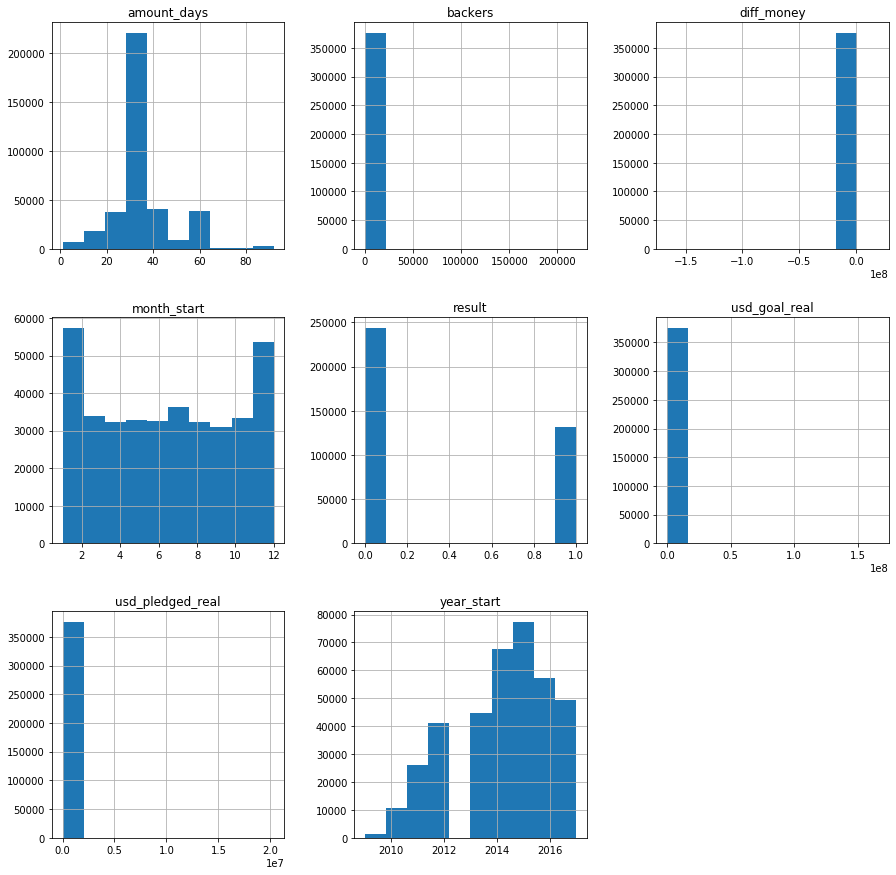

In [22]:
ks.hist()
fig=plt.gcf()
fig.set_size_inches(15,15)
plt.show()

In [23]:
round(ks.describe())

,result,year_start,month_start,amount_days,backers,usd_pledged_real,usd_goal_real,diff_money
count,375853.0,375853.0,375853.0,375853.0,375853.0,375853.0,375853.0,375853.0
mean,0.0,2014.0,6.0,34.0,106.0,9083.0,45328.0,-36245.0
std,0.0,2.0,3.0,13.0,910.0,91272.0,1145879.0,1148992.0
min,0.0,2009.0,1.0,1.0,0.0,0.0,0.0,-166361391.0
25%,0.0,2013.0,4.0,30.0,2.0,31.0,2000.0,-9999.0
50%,0.0,2014.0,6.0,30.0,12.0,628.0,5480.0,-1963.0
75%,1.0,2016.0,9.0,37.0,56.0,4065.0,15500.0,201.0
max,1.0,2017.0,12.0,92.0,219382.0,20338986.0,166361391.0,19838986.0


Стоит отметить что большая часть целей до 15,5 тысяч а взносов до 4 что более чем в три раза меньше.

In [24]:
round(ks[ks['result'] == 0].state.count() / (ks.state.count() / 100))

65.0

In [25]:
round(ks[ks['result'] == 1].state.count() / (ks.state.count() / 100))

35.0

Общее соотношение успех к провалу 35 на 65 процентов

Проанализируем динамику некоторых показателей во времени: количество проектов, количество успешных проектов, процент успеха, количество человек сделавших взносы, средняя сумма взноса.

In [26]:
backer_year = ks.groupby('year_start').sum().reset_index()

In [27]:
backer_year['mean_sum_year'] = round(backer_year.usd_pledged_real / backer_year.backers)

In [28]:
result_count = ks.groupby('year_start').count().reset_index()
result_count = result_count[['year_start', 'result']].rename(columns={'result': 'project_count'})

In [29]:
backer_year = backer_year.merge(result_count, on='year_start', how='left')

In [30]:
backer_year['percent_success'] = round(backer_year['result'] / ( backer_year['project_count'] / 100))

In [31]:
backer_year = backer_year[['year_start', 'project_count', 'result',
                           'percent_success', 'backers', 'mean_sum_year']].rename(columns={'result': 'count_success'})

In [32]:
backer_year.set_index('year_start', inplace=True)

In [33]:
backer_year

,project_count,count_success,percent_success,backers,mean_sum_year
year_start,,,,,
2009,1329,546,41.0,43758,65.0
2010,10519,4370,42.0,406875,72.0
2011,26237,11672,44.0,1396473,74.0
2012,41165,17381,42.0,4343786,74.0
2013,44851,19006,42.0,6292568,76.0
2014,67745,20968,31.0,6194576,85.0
2015,77300,21248,27.0,7512058,92.0
2016,57182,18492,32.0,7148549,92.0
2017,49525,18084,37.0,6463959,94.0


In [34]:
# средняя сумма взноса
ks.usd_pledged_real.sum() / ks.backers.sum() 

85.76910054925555

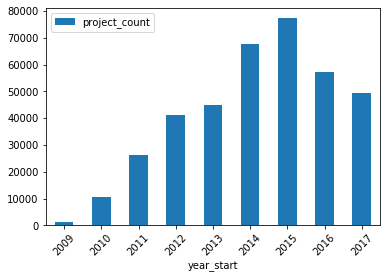

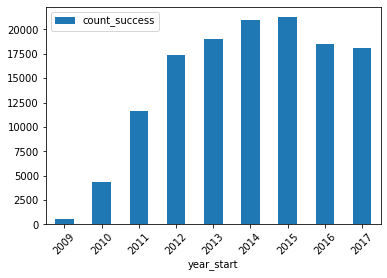

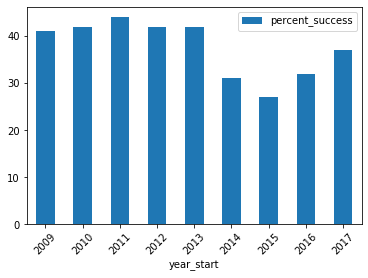

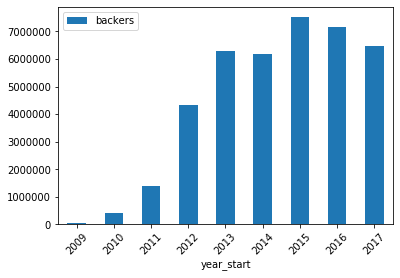

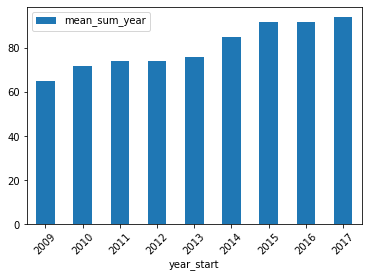

In [35]:
backer_year.project_count.plot(kind='bar', rot='45', legend=True)
plt.show()
backer_year.count_success.plot(kind='bar', rot='45', legend=True)
plt.show()
backer_year.percent_success.plot(kind='bar', rot='45', legend=True)
plt.show()
backer_year.backers.plot(kind='bar', rot='45', legend=True)
plt.show()
backer_year.mean_sum_year.plot(kind='bar', rot='45', legend=True)
plt.show()

Можно отметить:
    - количество проектов устойчиво росло до 2015 года затем пошел небольшой спад
    - количество успешных проектов движется в том же направлении но с 2012 года изменения не так ярко выражены
    - в процентном соотношении обратная динамика до 2015 года затем направляется в рост, это можно связать с тем что количество человек делающих взносы меняется не с такой скоростью с какой увеличивается количество проектов. Что логично количество инвесторов и успехов примерно на одном уровне а проектов становится больше. Стоит задуматься о привличении людей делающих взносы.
    - средний взнос имеет небольшую положительную динамику
2014 и 2015 годы можно назвать пиком активности для проекта

Посмотри распределение успешности по общим категориям, месяцам, и странам(отделим США и Британию для наглядности на графике так как в этих странах количество значительно больше)

In [36]:
ks_pivot_main_category = ks.pivot_table(index = 'main_category', columns = 'result', values='state', aggfunc = 'count')
ks_pivot_month = ks.pivot_table(index = 'month_start', columns = 'result', values='state', aggfunc = 'count')
ks_pivot_country_no_usgb = ks[
    (ks['country'] != 'US') & (ks['country'] != 'GB')
].pivot_table(index = 'country', columns = 'result', values='state', aggfunc = 'count')
ks_pivot_country_usgb = ks[
    (ks['country'] == 'US') | (ks['country'] == 'GB')
].pivot_table(index = 'country', columns = 'result', values='state', aggfunc = 'count')

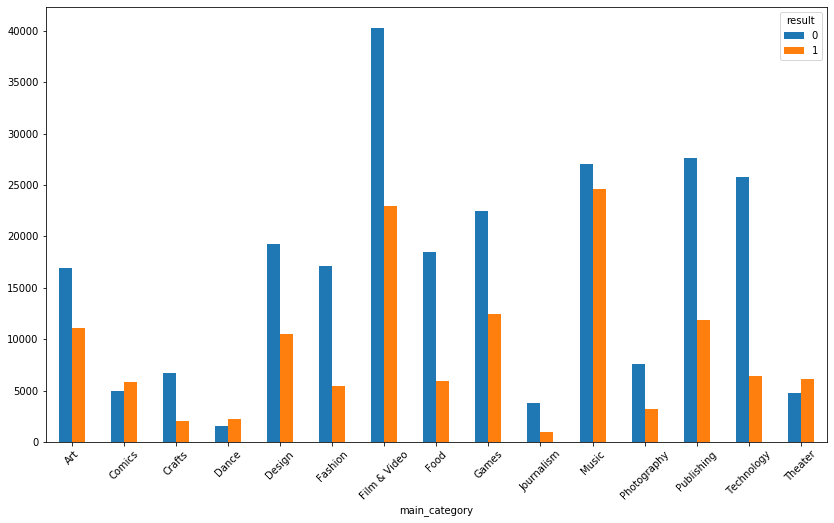

In [37]:
ks_pivot_main_category.plot(kind='bar', rot=45)
fig=plt.gcf()
fig.set_size_inches(14,8)
plt.show()

- Можно отметить что успешных проектов было больше в категориях: Comics, Dance, Theatre
    Можно сказать что в этих категориях шансы на успех выше чем в других. Также стоит отметить хорошие показатели в категории Music. 
- Более чем в два раз отстает количество успешных проектов в категориях: Crafts, Fashion, Food, Journalism, Technology
    В этих категориях шансы наоборот меньше
    
В целом заметно что предпочтение люди отдают проектам от искусства и развлечений и наоборот с производственными(товары, услуги) категориями.

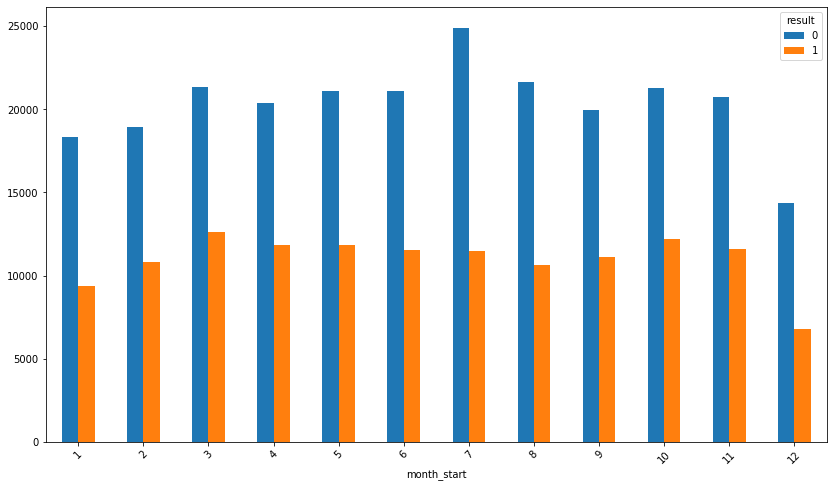

In [38]:
ks_pivot_month.plot(kind='bar', rot=45)
fig=plt.gcf()
fig.set_size_inches(14,8)
plt.show()

Немного чаще успешными становятся проекты начала весны и середины осени в целом разница не значительная. Похуже обстоят дела в декабре.

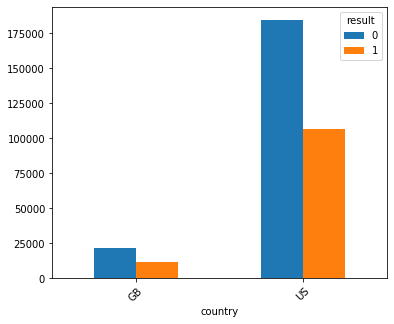

In [39]:
ks_pivot_country_usgb.plot(kind='bar', rot=45)
fig=plt.gcf()
fig.set_size_inches(6,5)
plt.show()

Наибольшей популярностью проект пользуется в США и Великобритании. В этих странах намного больше проектов в целом и не плохие шансы на их успех.

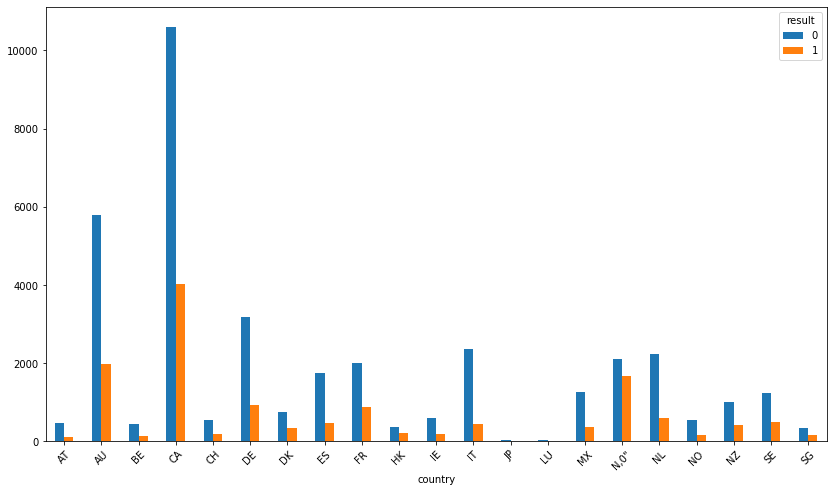

In [40]:
ks_pivot_country_no_usgb.plot(kind='bar', rot=45)
fig=plt.gcf()
fig.set_size_inches(14,8)
plt.show()

Немного меньше шансов у проектов из Италии, Австрии, Бельгии, Норвегии. Но в целом фактор страны не выглядит решающим для стран с маленьким количеством проектов.

Сделаем топ 10 категорий и стран по успешным проектам

In [41]:
ks_pivot_category = ks.pivot_table(index = 'category', columns = 'result', values='state', aggfunc = 'count')
ks_pivot_country = ks.pivot_table(index = 'country', columns = 'result', values='state', aggfunc = 'count')

In [42]:
ks_pivot_category.sort_values(1, ascending=False).head(10)

result,0,1
category,,
Product Design,14103,7974
Tabletop Games,6212,7859
Music,8206,7440
Shorts,6000,6311
Documentary,10286,5796
Theater,2866,4182
Indie Rock,2132,3510
Rock,3376,3351
Art,4921,3268


В целом по узким категориям что логично сохраняется та же динамика что и в общих.

In [43]:
ks_pivot_country.sort_values(1, ascending=False).head(10)

result,0,1
country,,
US,184659,106222
GB,21753,11639
CA,10592,4031
AU,5787,1982
"N,0""",2114,1682
DE,3176,920
FR,2000,887
NL,2231,602
SE,1236,501


Наибольшим количеством успешных проектов могут похвастать США, Великобритания что мы уже отмечали ранее. К ним можно добавить Канаду и Австралию.

Можно сделать вывод что у англоязычных стран дела на Kickstarter в целом обстоят лучше.

Топ 10 категорий в которых ищут поддержку

In [44]:
ks_pivot_main_category['count'] = ks_pivot_main_category[0] + ks_pivot_main_category[1]
ks_pivot_main_category.sort_values('count', ascending=False).head(10)

result,0,1,count
main_category,,,
Film & Video,40292,22959,63251
Music,27040,24596,51636
Publishing,27669,11905,39574
Games,22491,12452,34943
Technology,25740,6452,32192
Design,19237,10527,29764
Art,16886,11072,27958
Food,18477,5941,24418
Fashion,17079,5487,22566


In [45]:
ks_pivot_category['count'] = ks_pivot_category[0] + ks_pivot_category[1]
ks_pivot_category.sort_values('count', ascending=False).head(10)

result,0,1,count
category,,,
Product Design,14103,7974,22077
Documentary,10286,5796,16082
Music,8206,7440,15646
Tabletop Games,6212,7859,14071
Shorts,6000,6311,12311
Video Games,9380,2364,11744
Food,8226,3228,11454
Film & Video,6828,3224,10052
Fiction,6986,2134,9120


Можно сделать вывод, что чаще всего поддержку ищут проекты развлекательного типа и новых технологий.

Оценим влияние суммы цели на успешность

In [46]:
print(ks.usd_goal_real.quantile(.95), 
      ks.usd_goal_real.quantile(.85)
     )

80000.0 30000.0


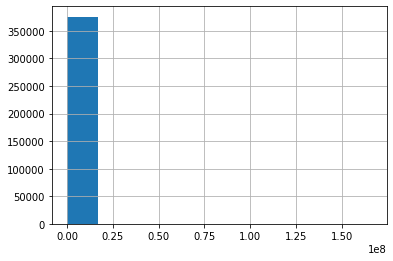

In [47]:
ks.usd_goal_real.hist()

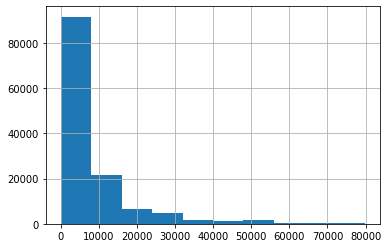

In [48]:
ks[(ks['result'] == 1) & (ks['usd_goal_real'] < 80000)].usd_goal_real.hist()

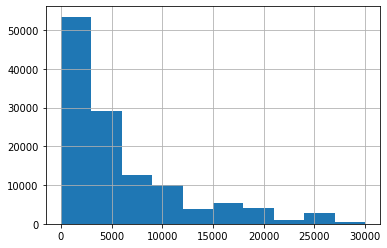

In [49]:
ks[(ks['result'] == 1) & (ks['usd_goal_real'] < 30000)].usd_goal_real.hist()

По графикам видно, что чем выше сумма цели тем меньше количество проектов закончившихся успехом. После 5000$ статистика резко ухудшается.

Можно сделавть вывод - чем больше сумма цели тем меньше шансов ее собрать.

Определим в каких странах какие категории наиболее успешны

In [50]:
ks_pivot_main_category_country = ks.pivot_table(index = 'main_category',
                                                columns = 'country', values='result', aggfunc = 'sum')

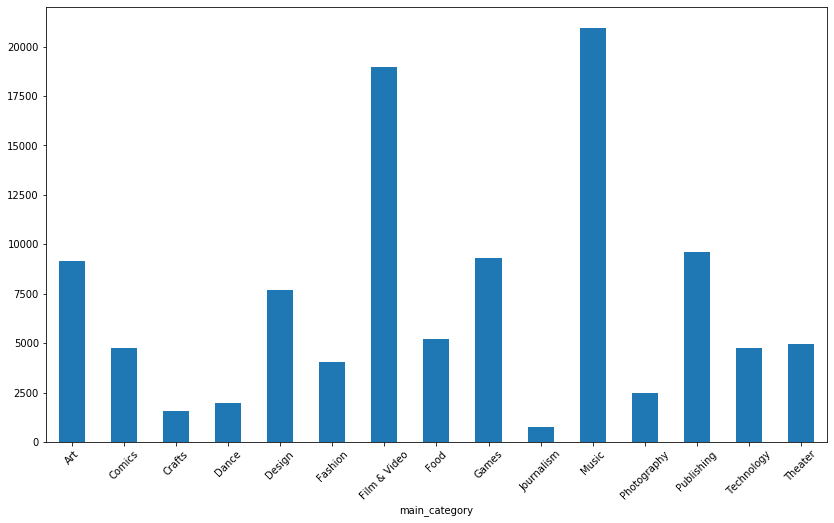

In [51]:
ks_pivot_main_category_country.US.plot(kind='bar', rot=45)
fig=plt.gcf()
fig.set_size_inches(14,8)
plt.show()

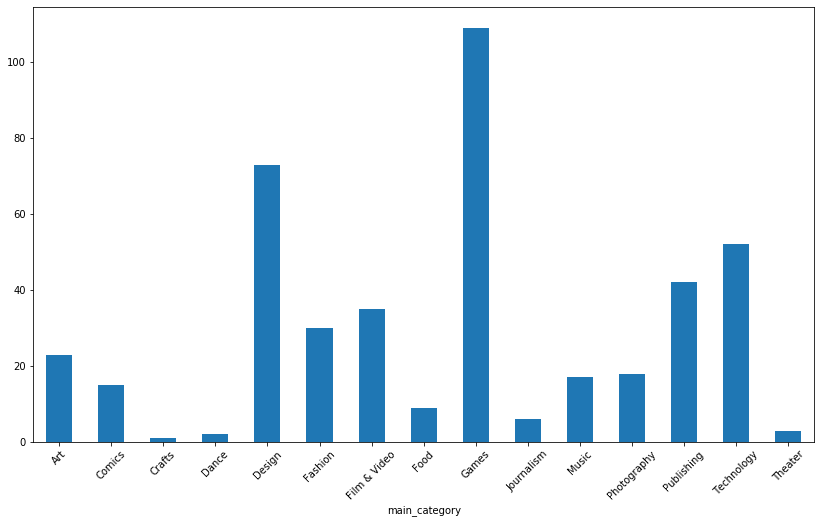

In [52]:
ks_pivot_main_category_country.IT.plot(kind='bar', rot=45)
fig=plt.gcf()
fig.set_size_inches(14,8)
plt.show()

In [53]:
ks_pivot_main_category_country = ks_pivot_main_category_country.reset_index()

In [54]:
ks_pivot_main_category_country

country,main_category,AT,AU,BE,CA,CH,DE,DK,ES,FR,...,JP,LU,MX,"N,0""",NL,NO,NZ,SE,SG,US
0,Art,5.0,130.0,12.0,310.0,15.0,62.0,42.0,46.0,60.0,...,0.0,0.0,38.0,NaN,36.0,6.0,29.0,40.0,11.0,9137.0
1,Comics,3.0,98.0,1.0,292.0,3.0,12.0,4.0,11.0,14.0,...,NaN,0.0,12.0,NaN,8.0,11.0,8.0,19.0,4.0,4777.0
2,Crafts,1.0,36.0,3.0,100.0,5.0,24.0,7.0,8.0,20.0,...,NaN,NaN,14.0,NaN,8.0,2.0,2.0,7.0,7.0,1589.0
3,Dance,1.0,15.0,1.0,32.0,0.0,6.0,1.0,0.0,4.0,...,NaN,NaN,11.0,0.0,3.0,2.0,2.0,3.0,0.0,1987.0
4,Design,21.0,317.0,29.0,480.0,53.0,186.0,64.0,46.0,134.0,...,0.0,2.0,26.0,1.0,100.0,20.0,55.0,63.0,66.0,7664.0
5,Fashion,10.0,145.0,13.0,299.0,20.0,61.0,28.0,39.0,74.0,...,3.0,1.0,8.0,0.0,68.0,13.0,19.0,29.0,24.0,4032.0
6,Film & Video,8.0,232.0,12.0,483.0,10.0,80.0,46.0,45.0,99.0,...,0.0,0.0,107.0,342.0,28.0,18.0,76.0,45.0,1.0,18996.0
7,Food,4.0,55.0,4.0,182.0,7.0,23.0,10.0,12.0,24.0,...,NaN,0.0,16.0,0.0,16.0,8.0,19.0,19.0,5.0,5231.0
8,Games,11.0,271.0,22.0,496.0,18.0,151.0,25.0,134.0,162.0,...,1.0,0.0,28.0,1.0,98.0,17.0,66.0,86.0,27.0,9302.0
9,Journalism,0.0,15.0,0.0,30.0,0.0,6.0,10.0,6.0,9.0,...,NaN,1.0,2.0,0.0,4.0,2.0,6.0,13.0,0.0,758.0


In [55]:
def top_category_for_country(df):
    countries = list(df)
    top_category = {}
    for place in countries:
        key = place
        value = df[df[place] == df[place].max()].reset_index().at[0, 'main_category']
        top_category[key] = value
    return top_category        

Топ успешных категорий по странам

In [56]:
top_category_for_country(ks_pivot_main_category_country)

{'main_category': 'Theater',
 'AT': 'Design',
 'AU': 'Design',
 'BE': 'Design',
 'CA': 'Games',
 'CH': 'Design',
 'DE': 'Design',
 'DK': 'Design',
 'ES': 'Games',
 'FR': 'Games',
 'GB': 'Film & Video',
 'HK': 'Design',
 'IE': 'Publishing',
 'IT': 'Games',
 'JP': 'Fashion',
 'LU': 'Photography',
 'MX': 'Film & Video',
 'N,0"': 'Music',
 'NL': 'Design',
 'NO': 'Music',
 'NZ': 'Film & Video',
 'SE': 'Games',
 'SG': 'Design',
 'US': 'Music'}

Посмотрим сколько в среднем успешные проекты получали сверх цели, и сколько в среднем не хватало не успешным. Возьмем медиану так как существует ряд проектов с очень высокими или низкими показателями. Медианный показатель будет ближе для оценки среднестатистического проекта.

In [57]:
round(ks[ks['result']==1].usd_goal_real.median())

4000

In [58]:
round(ks[ks['result']==1].diff_money.median())

584

In [59]:
round(ks[ks['result']==0].usd_goal_real.median())

7500

In [60]:
round(ks[ks['result']==0].diff_money.median())

-6434

- Можно отметить что в среднем успешные проекты наберают немного больше средств (примерно + 25%).
- А не успешные в свою очередь не добирают большей части (примерно 90%)

Можно предположить что проекты обреченные на провал очевидны для большинства.

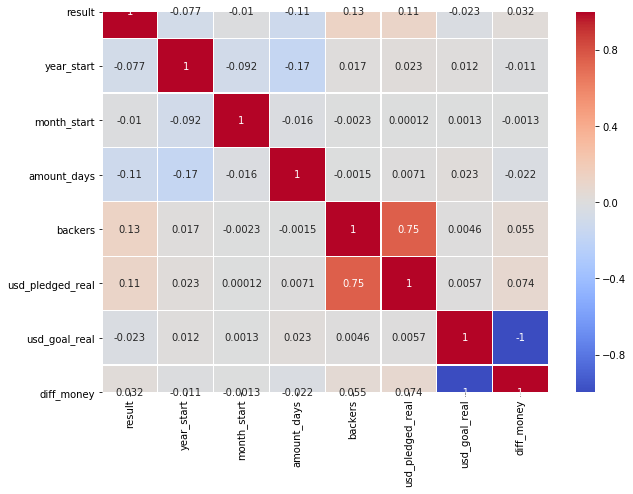

In [61]:
sns.heatmap(ks.corr(), annot=True, linewidths=0.3, cmap='coolwarm')
fig=plt.gcf()
fig.set_size_inches(10,7)

Значимых для исследования неочевидных взвимосвязей выявить не удалось

## Выдвинем гипотезу, что проекты из США , в категории Комиксы и Театр, стартовавшие в марте или октябре более успешны чем остальные. 

In [62]:
target_sample = ks[
    (ks['country'] == 'US')  & 
    ((ks['main_category'] == 'Comics') | (ks['main_category'] == 'Theater')) & 
    ((ks['month_start'] == 3) | (ks['month_start'] == 10))
].result
other_sample = ks[
    (ks['country'] != 'US') & 
    (ks['main_category'] != 'Comics') & (ks['main_category'] != 'Theater') & 
    ((ks['month_start'] != 3) & (ks['month_start'] != 10))
].result.sample(3184)

In [63]:
statistics.variance(target_sample), statistics.variance(other_sample)

(0.24525934337095467, 0.1996353705378921)

In [64]:
stats.ttest_ind(target_sample, other_sample)

Ttest_indResult(statistic=24.869135945751164, pvalue=2.267910212482404e-130)

In [65]:
descriptives, results = rp.ttest(target_sample, other_sample)

In [66]:
descriptives

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,result,3184.0,0.569410,0.495237,0.008777,0.552201,0.586618
1,result,3184.0,0.275440,0.446806,0.007918,0.259914,0.290965
2,combined,6368.0,0.422425,0.493984,0.006190,0.410290,0.434560


Тест на дисперсию показал что выборки не имеют значительные отклонения по дисперсии.

pvalue < 0.05 значит выборки статистически различны, так же на это указывает различие средних показателей отвергаем нулевую гипотезу.

Выборки статистически различны. В целевой группе средний показатель выше в два раза, наша гипотеза верна.

## Построение предективной модели определения успешности проекта. Определение факторов наиболее влияющих на результат

Изменим текстовые данные на числовые

In [67]:
ks_1 = ks.copy()

In [68]:
ks_1 = ks_1[['result', 'category', 'main_category', 'country',
       'month_start', 'amount_days', 'usd_goal_real',]]

In [69]:
ks_1 = pd.get_dummies(ks_1, columns=['main_category'])

In [70]:
label = LabelEncoder()
dicts = {}

label.fit(ks_1.category)
dicts['category'] = list(label.classes_)
ks_1.category = label.transform(ks_1.category)

label.fit(ks_1.country)
dicts['country'] = list(label.classes_)
ks_1.country = label.transform(ks_1.country)

In [71]:
input_x = ks_1.iloc[:, 1:]
Y = ks_1['result']

In [72]:
x_train, x_test, y_train, y_test = train_test_split(input_x, Y, test_size=0.25)

Построим модель Random Forest

In [73]:
model = RandomForestClassifier(n_estimators=100)
model.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Определим наиболее важные атрибуты для успешности проекта

No handles with labels found to put in legend.


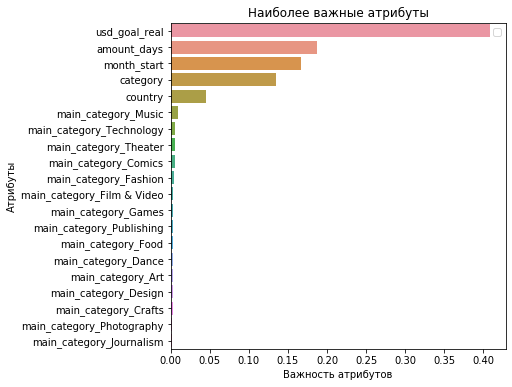

In [74]:
headers = list(x_train.columns.values)

feature_imp = pd.Series(model.feature_importances_, index=headers).sort_values(ascending=False)

f, ax = plt.subplots(figsize=(6, 6))
sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel('Важность атрибутов')
plt.ylabel('Атрибуты')
plt.title('Наиболее важные атрибуты')
plt.legend()
plt.show()

Самым значительным оказался фактор требуемой суммы 

Оценим точность модели

In [75]:
model_pred = model.predict(x_test)
print(classification_report(y_test, model_pred))

              precision    recall  f1-score   support

           0       0.72      0.79      0.75     60951
           1       0.53      0.42      0.47     33013

    accuracy                           0.66     93964
   macro avg       0.62      0.61      0.61     93964
weighted avg       0.65      0.66      0.65     93964



In [76]:
model.score(x_test, y_test)

0.6635413562641012

Другие варианты модели:

In [77]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(x_train, y_train)

In [78]:
clf.score(x_test, y_test)

0.649110297560768

In [79]:
from sklearn.neighbors import KNeighborsClassifier
model_knc = KNeighborsClassifier(n_neighbors = 18).fit(x_train, y_train)

In [80]:
model_knc.score(x_test, y_test)

0.6642118258056277

Наша модель может предсказать результат с вероятностью 66%, что нельзя назвать приемлимым результатом

Можно сделать вывод что имеющийся датасет не подходит для построения качественной предиктивной модели.

Для улучшения показателей модели может помочь добавление таких факторов как: информация о компании выдвигающей проект(количество проектов, количество успешных проектов, год основания компании), ключевые слова характеризующие проект.